In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Посмотрим на наши данные

In [2]:
df = pd.read_csv('train.csv')
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [3]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# Анализ данных

Посмотрим на информацию о категориальных признаках

In [4]:
for col in cat_cols:
  print(df[col].value_counts())

Male      2655
Female    2627
Name: Sex, dtype: int64
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64
No     2705
Yes    2577
Name: HasPartner, dtype: int64
No     3676
Yes    1606
Name: HasChild, dtype: int64
Yes    4761
No      521
Name: HasPhoneService, dtype: int64
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64
No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64
No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64
No    

Посмотрим на типы данных у числовых признаков 

In [5]:
df[num_cols].dtypes

ClientPeriod         int64
MonthlySpending    float64
TotalSpent          object
dtype: object

Обратим внимание что у колонки `TotalSpent` тип `object`. Вероятно, некоторые ячейки содержат мусор. Посмотрим на посорченные значения колонки.

In [6]:
df.TotalSpent.sort_values()

4598          
2543          
4551          
1707          
3078          
         ...  
3557    996.85
141     996.95
4317    997.65
3376     998.1
1157     999.9
Name: TotalSpent, Length: 5282, dtype: object

Можно заметить что некоторые значения равны `' '`

In [7]:
df[df.TotalSpent == ' '].TotalSpent.count()

9

Заменим их на значение 0 и приведем к типу float

In [8]:
def total_spent_fix(df):
  return df.TotalSpent.replace(' ', '0').astype('float')
df.TotalSpent = total_spent_fix(df)

Выведем гистограммы для числовых признаков

<ipython-input-9-6ee581bb9493>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, id + 1)


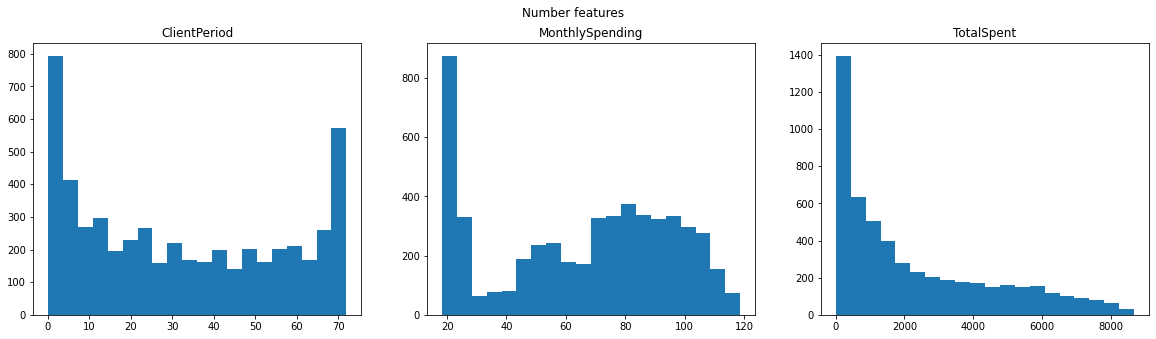

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.suptitle('Number features')
for id, col in enumerate(num_cols):
  plt.subplot(1, 3, id + 1)
  plt.hist(df[col], bins=20)
  plt.title(col)
plt.show()

Теперь для категориальных

<ipython-input-10-e3bdd94c9932>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, id + 1)


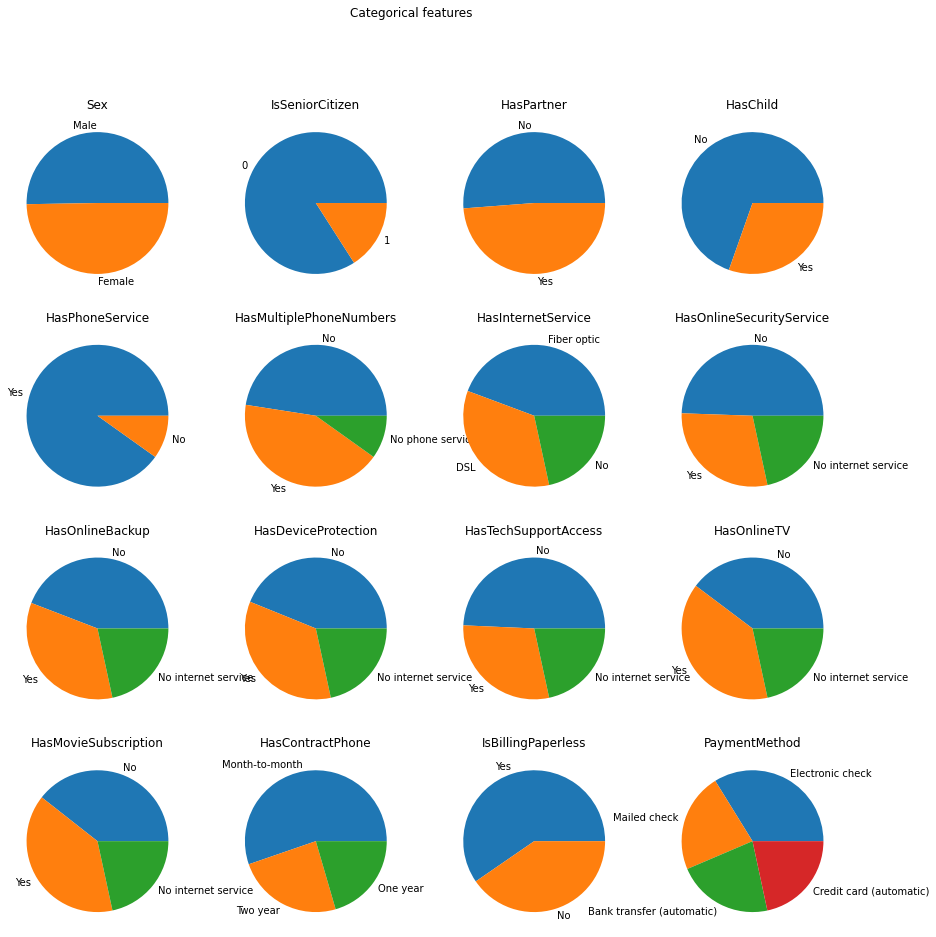

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.suptitle('Categorical features')
for id, col in enumerate(cat_cols):
  plt.subplot(4, 4, id + 1)
  plt.pie(df[col].value_counts(), labels=df[col].value_counts().index)
  plt.title(col)
plt.show()

Посмотрим на распределение целевой переменной

In [11]:
df[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

# Применение линейных моделей

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

Стандартизируем данные и создадим отдельный датафрейм для фич

In [13]:
def standart(df):
  df.TotalSpent = total_spent_fix(df)
  X = df[num_cols]
  scaler = StandardScaler()
  X = np.hstack([X, pd.get_dummies(df[cat_cols])])
  X = scaler.fit_transform(X)
  return X

Создадим отдельный датафрейм для фич

In [14]:
X = standart(df)
y = df[target_col]
X

array([[ 0.92076704, -1.50544655, -0.55585201, ..., -0.52550324,
        -0.7147514 ,  1.85034743],
       [ 1.61328776, -1.29499774, -0.18303943, ...,  1.90293782,
        -0.7147514 , -0.54043905],
       [-1.27900465,  0.36373662, -0.97476756, ..., -0.52550324,
         1.39908785, -0.54043905],
       ...,
       [-1.27900465, -0.32726461, -0.9839573 , ..., -0.52550324,
        -0.7147514 ,  1.85034743],
       [-0.13838229,  0.36705077, -0.03183845, ...,  1.90293782,
        -0.7147514 , -0.54043905],
       [-0.54574742,  0.36373662, -0.40191834, ..., -0.52550324,
        -0.7147514 ,  1.85034743]])

Применим кросс-валидацию и обучим модель с помощью логичстической регрессии

In [ ]:
clf = LogisticRegression()
params = {'C' : np.linspace(1, 15, 50), 'max_iter' : np.array([1000])}
grid = GridSearchCV(clf, param_grid = params, refit = True, verbose = 1)

epochs = 10

for epoch in range(epochs):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  grid.fit(X_train, y_train)
  print(roc_auc_score(y_test, grid.predict_proba(X_test).T[1]))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.8479662104567527
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
grid.best_params_

In [ ]:
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv', index_col=0)
pred = grid.predict_proba(standart(test)).T[1]
submission.Churn = pred
submission.to_csv('submission.csv')

# Применение градиентного бустинга

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
X = pd.concat([df[cat_cols], df[num_cols]], axis=1)
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=343)

In [ ]:
model = CatBoostClassifier(
    n_estimators=200
)

model.fit(
      X_train, y_train,
      cat_features=cat_cols,
      eval_set=(X_test, y_test),
      verbose=False
)

In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test).T[1])

In [ ]:
test = pd.read_csv('test.csv')
test.TotalSpent = total_spent_fix(test)
submission = pd.read_csv('submission.csv', index_col=0)
X_ = pd.concat([test[cat_cols], test[num_cols]], axis=1)
pred = model.predict_proba(X_).T[1]
submission.Churn = pred
submission.to_csv('submission.csv')